In [1]:
import pprint

import ee
from IPython.display import Image

ee.Initialize()

In [2]:
tmax_coll_id = 'NASA/ORNL/DAYMET_V4'
tmax_band = 'tmax'
tmax_dimensions = [4500, 3000]
tmax_transform = [1000, 0, -1999750, 0, -1000, 1109500]

doy = 100
year_start = 1981
year_end = 2010

viridis = ['440154', '433982', '30678D', '218F8B', '36B677', '8ED542', 'FDE725']
image_size = 768

# Yosemite
# study_area = ee.Geometry.BBox(-120.00, 36.5, -118.00, 37.5)
# Denver
study_area = ee.Geometry.BBox(-105.50, 38.75, -103.50, 39.75)

study_region = study_area.bounds(1, 'EPSG:4326').coordinates().getInfo()

In [3]:
def c_to_k(image):
    """Convert temperature from C to K"""
    return image.add(273.15).copyProperties(image, ['system:time_start'])

### Elevation Image

In [4]:
srtm = ee.Image("CGIAR/SRTM90_V4")
srtm_proj = srtm.projection()
srtm_crs = srtm_proj.getInfo()['crs']

size = 200
srtmProjection20km = srtm_proj.scale(size, size);
print('SRTM Orig scale:', srtm_proj.nominalScale().getInfo())
print('SRTM Proj scale (for median):', srtmProjection20km.nominalScale().getInfo())

SRTM Orig scale: 92.76624232769086
SRTM Proj scale (for median): 18553.24846553817


### Tmax Image

In [5]:
tmax_coll = ee.ImageCollection(tmax_coll_id).select([tmax_band])
tmax_doy_coll = tmax_coll \
    .filter(ee.Filter.calendarRange(doy, doy, 'day_of_year')) \
    .filter(ee.Filter.calendarRange(year_start, year_end, 'year')) \
    .map(c_to_k)
tmax_img = ee.Image(tmax_doy_coll.mean())

tmax_info = ee.Image(tmax_coll.first()).getInfo()
tmax_proj = ee.Image(tmax_coll.first()).projection()
tmax_crs = tmax_proj.getInfo()['wkt'].replace(' ', '').replace('\n', '')

# image_url = tmax_img\
#     .reproject(crs=tmax_crs, crsTransform=tmax_transform)\
#     .getThumbURL({'min': 270, 'max': 310, 'palette': viridis, 
#                   'region': study_region, 'dimensions': image_size})
# Image(image_url, embed=True, format='png')

### Fill the Tmax Image

In [6]:
filled_img = tmax_img.focal_mean(4000, 'circle', 'meters') \
    .reproject(crs=tmax_crs, crsTransform=tmax_transform)
tmax_img = filled_img.where(tmax_img.gt(0), tmax_img)

# image_url = tmax_img\
#     .getThumbURL({'min': 270, 'max': 310, 'palette': viridis, 
#                   'region': study_region, 'dimensions': image_size})
# Image(image_url, embed=True, format='png')

### Apply the ELR adjustment

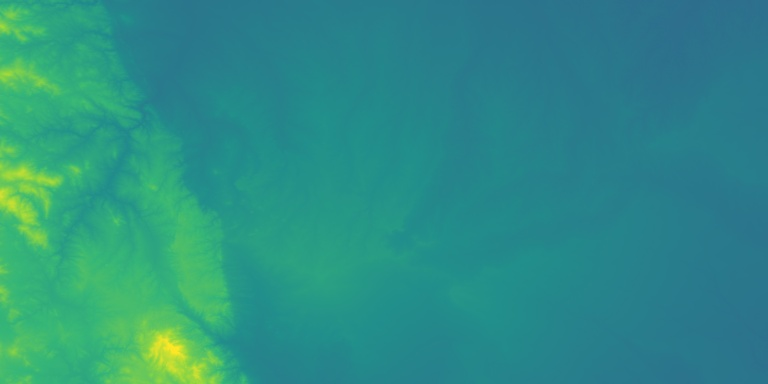

In [7]:
# Reduce DEM to median of ~20km cells
srtmMedian = srtm.reduceResolution(reducer=ee.Reducer.median(), maxPixels=65536)

image_url = srtmMedian\
    .getThumbURL({'min': 0, 'max': 4000, 'palette': viridis, 
                  'region': study_region, 'dimensions': image_size})
#     .reproject(crs=srtm_crs, scale=1000)\
# print(image_url)
Image(image_url, embed=True, format='png')

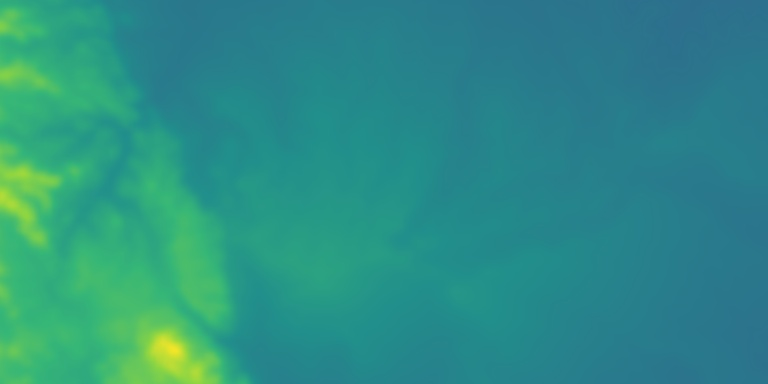

In [8]:
# Smooth median DEM with 5x5 pixel radius
srtmMedian_5x5 = srtmMedian\
    .reduceNeighborhood(reducer=ee.Reducer.mean(),
                        kernel=ee.Kernel.square(radius=5, units='pixels'))
image_url = srtmMedian_5x5\
    .getThumbURL({'min': 0, 'max': 4000, 'palette': viridis, 
                  'region': study_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

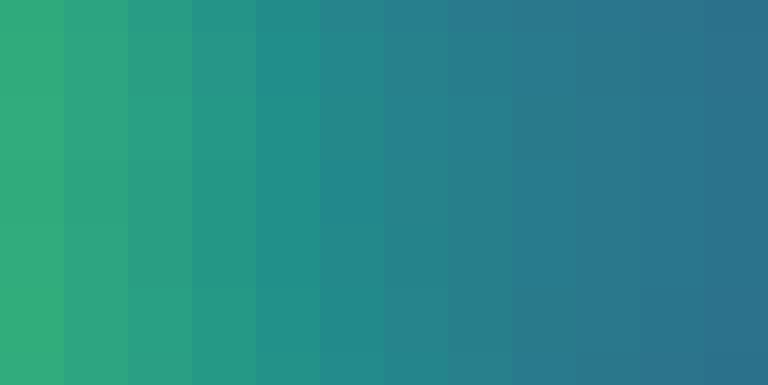

In [9]:
# Reproject to ~20km
srtmMedian20km = srtmMedian_5x5.reproject(srtmProjection20km)
image_url = srtmMedian20km\
    .getThumbURL({'min': 0, 'max': 4000, 'palette': viridis, 
                  'region': study_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### Check if building the srtm image all at once is the same as above (it is)

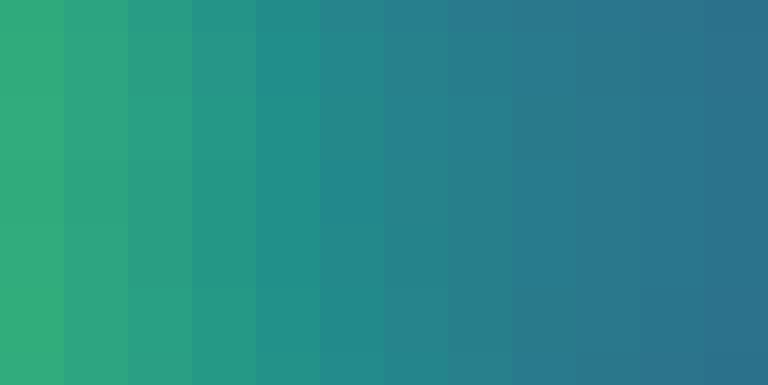

In [10]:
# Reproject to ~20km
srtmMedian20km_test = srtm\
    .reduceResolution(reducer=ee.Reducer.median(), maxPixels=65536)\
    .reduceNeighborhood(reducer=ee.Reducer.mean(),
                        kernel=ee.Kernel.square(radius=5, units='pixels'))\
    .reproject(srtmProjection20km)
image_url = srtmMedian20km_test\
    .getThumbURL({'min': 0, 'max': 4000, 'palette': viridis, 
                  'region': study_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

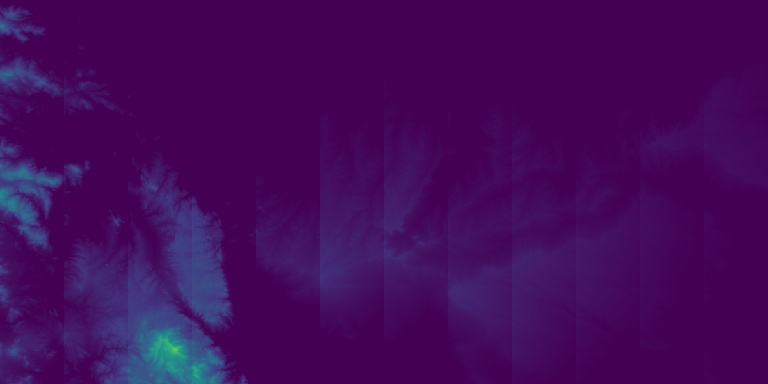

In [11]:
# Final ELR mask: (DEM-(medDEM.add(100)).gt(0))
srtm_diff = srtm.subtract(srtmMedian20km.add(100))
image_url = srtm_diff\
    .getThumbURL({'min': 0, 'max': 2500, 'palette': viridis, 
                  'region': study_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

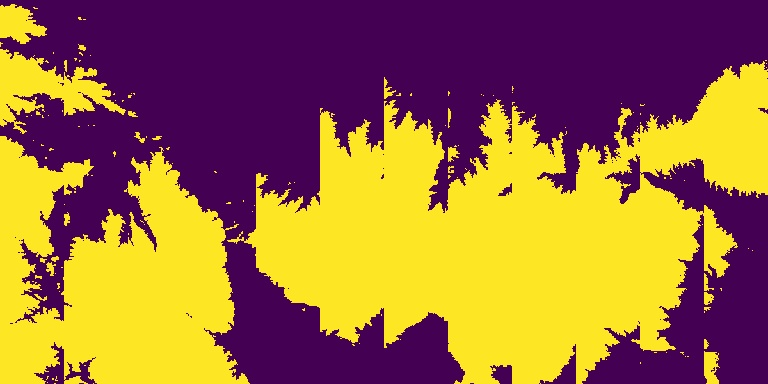

In [12]:
srtm_mask = srtm_diff.gt(0)
image_url = srtm_mask\
    .getThumbURL({'min': 0, 'max': 1, 'palette': viridis, 
                  'region': study_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

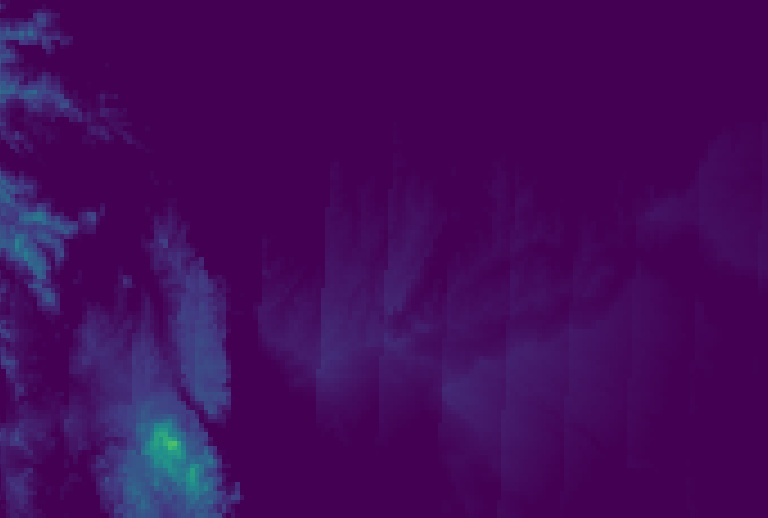

In [13]:
# Reproject to match Tmax source projection
srtm_diff = srtm_diff.reproject(tmax_proj)
image_url = srtm_diff\
    .getThumbURL({'min': 0, 'max': 2500, 'palette': viridis, 
                  'region': study_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

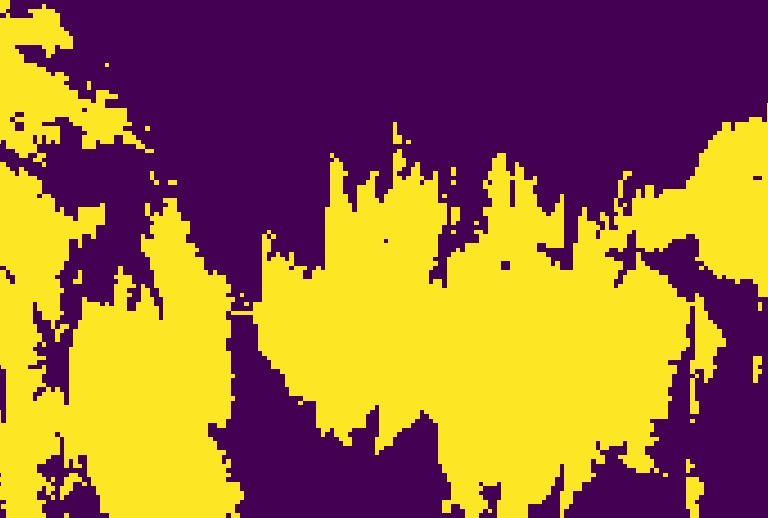

In [14]:
srtm_mask = srtm_mask.reproject(tmax_proj)
image_url = srtm_mask\
    .getThumbURL({'min': 0, 'max': 1, 'palette': viridis, 
                  'region': study_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

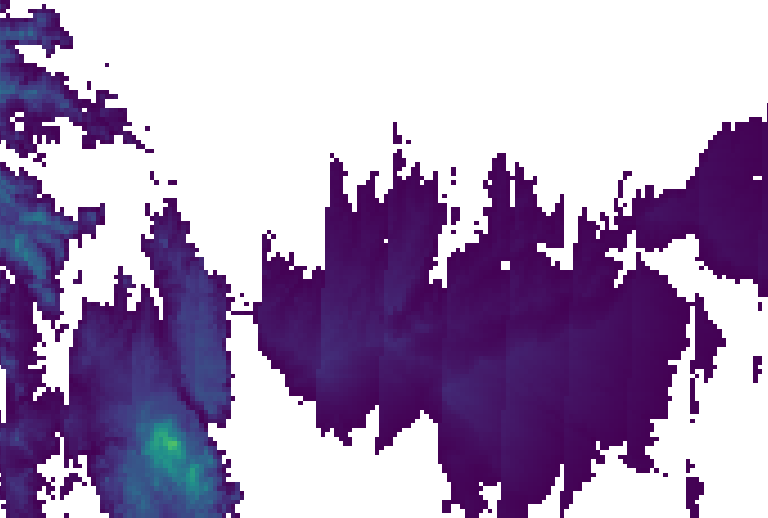

In [15]:
srtm_diff_final = srtm_diff.mask(srtm_mask)
image_url = srtm_diff_final\
    .getThumbURL({'min': 0, 'max': 2500, 'palette': viridis, 
                  'region': study_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

In [16]:
# elr_adjust = ee.Image(tmax_img).expression(
#     '(temperature - (0.005 * (elr_layer)))',
#     {'temperature': tmax_img, 'elr_layer': srtm_diff_final})

# tmax_img = tmax_img.where(srtm_diff_final, elr_adjust)
# # pprint.pprint(tmax_img.getInfo())

# image_url = tmax_img\
#     .getThumbURL({'min': 270, 'max': 310, 'palette': viridis, 
#                   'region': study_region, 'dimensions': image_size})
# #     .reproject(crs=tmax_crs, scale=1000)\
# Image(image_url, embed=True, format='png')

### Different approach using SRTM resampled to Tmax grid

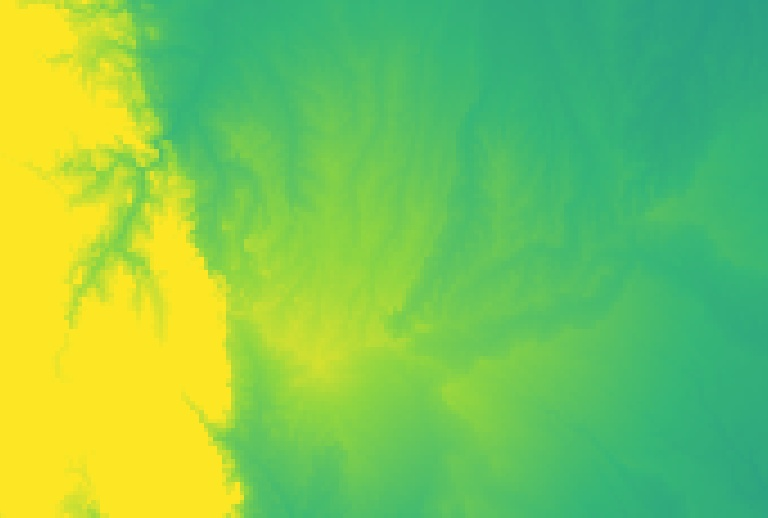

In [18]:
# First resample/reduce the 90m SRTM image to the 1km DAYMET grid
# These approaches should all be basically the same at this scale
srtm_tmax_fine = srtm.reproject(crs=tmax_proj)
# srtm_tmax_fine = srtm.resample('bilinear').reproject(crs=tmax_proj)
# srtm_tmax_fine = srtm\
#     .reduceResolution(reducer=ee.Reducer.median(), maxPixels=65536)\
#     .reproject(crs=tmax_proj)

image_url = srtm_tmax_fine\
    .getThumbURL({'min': 0, 'max': 2500, 'palette': viridis, 
                  'region': study_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

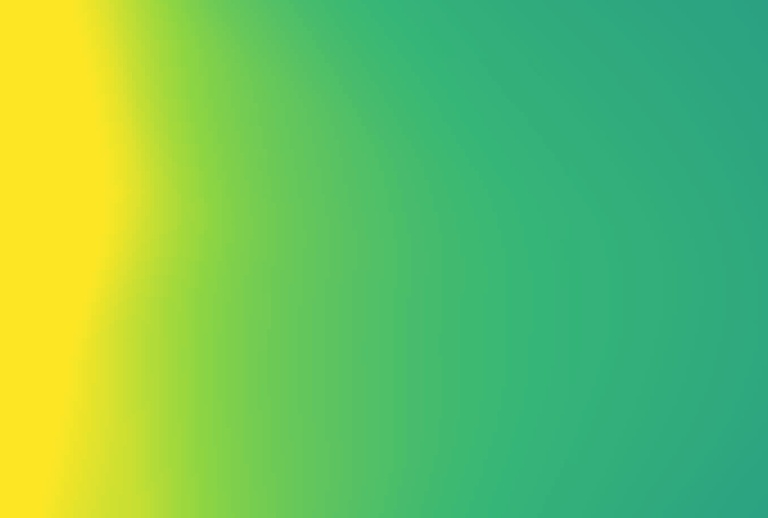

In [19]:
# Then generate the coarse resolution SRTM image
# Setting the radius to ~80 seems to get close to what was generated in the other script
#   For 1km DAYMET cells this is a 181km x 181km window
#   This is pretty similar to the 20km cells smoothed with a 9x9 window
#     (In the other script the radius was 5, which would be a 9x9 window, not 5x5)
# The images started to look reasonable for radius values >50
srtm_tmax_coarse = srtm_tmax_fine\
    .reduceNeighborhood(reducer=ee.Reducer.median(), kernel=ee.Kernel.square(radius=80, units='pixels'))\
    .reproject(crs=tmax_proj)

image_url = srtm_tmax_coarse\
    .getThumbURL({'min': 0, 'max': 2500, 'palette': viridis, 
                  'region': study_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

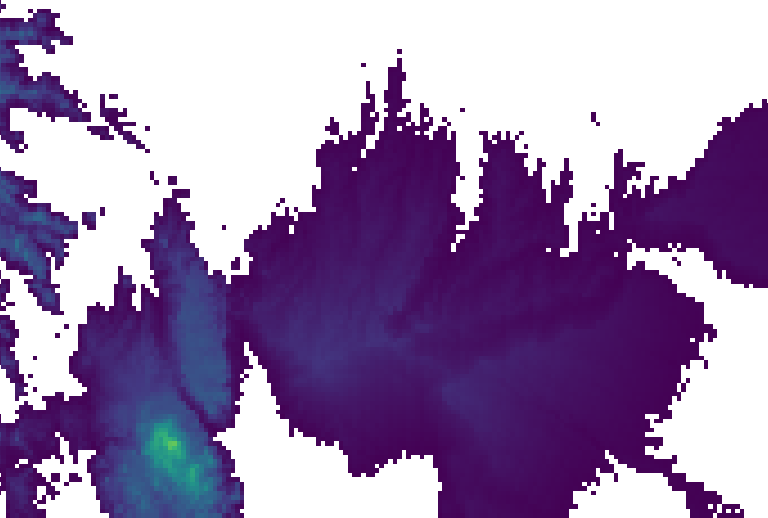

In [20]:
srtm_diff = srtm_tmax_fine.subtract(srtm_tmax_coarse.add(100))
srtm_mask = srtm_diff.gt(0)
srtm_diff_final = srtm_diff.mask(srtm_mask)
image_url = srtm_diff_final\
    .getThumbURL({'min': 0, 'max': 2500, 'palette': viridis, 
                  'region': study_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

In [ ]:
# Trying out using a median reducer (this seems to be a little slower than the mean)
srtm_tmax_coarse = srtm_tmax_fine\
    .reduceNeighborhood(reducer=ee.Reducer.median(), kernel=ee.Kernel.circle(radius=80, units='pixels'))\
    .reproject(crs=tmax_proj)
srtm_diff = srtm_tmax_fine.subtract(srtm_tmax_coarse.add(100))
srtm_mask = srtm_diff.gt(0)
srtm_diff_final = srtm_diff.mask(srtm_mask)
image_url = srtm_diff_final\
    .getThumbURL({'min': 0, 'max': 2500, 'palette': viridis, 
                  'region': study_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

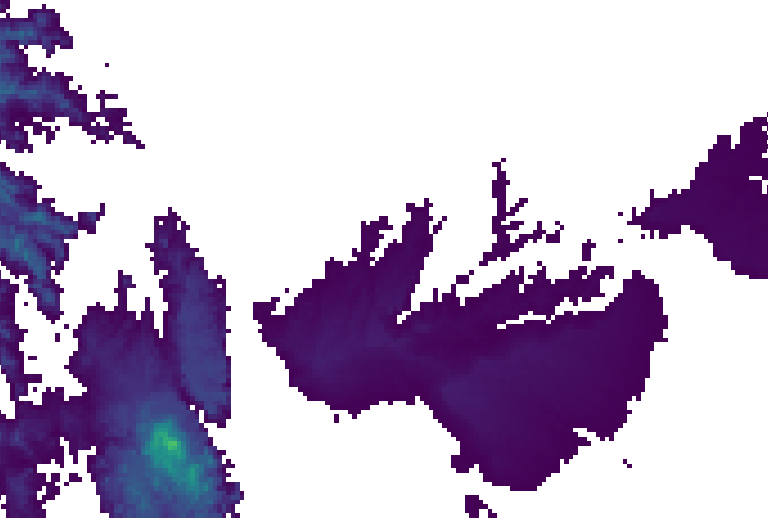

In [22]:
# Trying out a square kernel
srtm_tmax_coarse = srtm_tmax_fine\
    .reduceNeighborhood(reducer=ee.Reducer.mean(), kernel=ee.Kernel.square(radius=80, units='pixels'))\
    .reproject(crs=tmax_proj)
srtm_diff = srtm_tmax_fine.subtract(srtm_tmax_coarse.add(100))
srtm_mask = srtm_diff.gt(0)
srtm_diff_final = srtm_diff.mask(srtm_mask)
image_url = srtm_diff_final\
    .getThumbURL({'min': 0, 'max': 2500, 'palette': viridis, 
                  'region': study_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

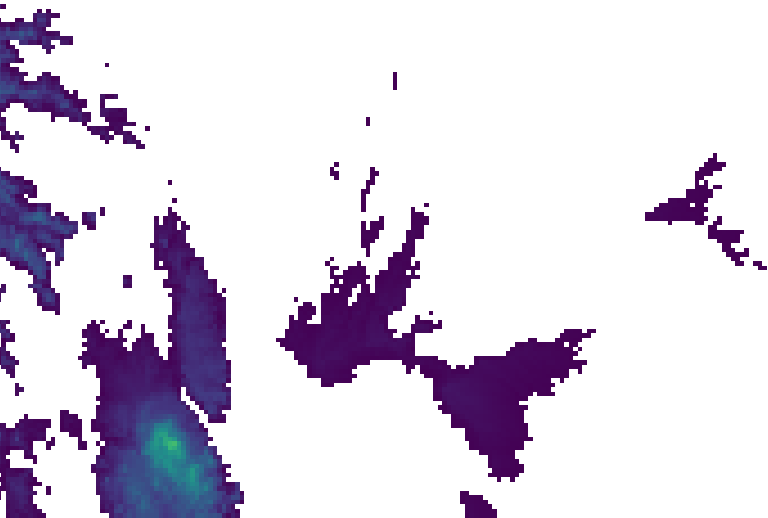

In [23]:
# Trying out a radius of 50
srtm_tmax_coarse = srtm_tmax_fine\
    .reduceNeighborhood(reducer=ee.Reducer.mean(), kernel=ee.Kernel.circle(radius=50, units='pixels'))\
    .reproject(crs=tmax_proj)
srtm_diff = srtm_tmax_fine.subtract(srtm_tmax_coarse.add(100))
srtm_mask = srtm_diff.gt(0)
srtm_diff_final = srtm_diff.mask(srtm_mask)
image_url = srtm_diff_final\
    .getThumbURL({'min': 0, 'max': 2500, 'palette': viridis, 
                  'region': study_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')